In [29]:
using ModelingToolkit, OrdinaryDiffEq
using ModelingToolkit: t_nounits as t, D_nounits as D

using CoolProp.CoolProp
using CoolProp.CoolProp: PropsSI
using BenchmarkTools
using Plots

In [30]:
## Inputs
# Fluid parameters
fluid_name = "Hydrogen"
eos = "TTSE&HEOS"
fluid_model = AbstractState_factory(eos, fluid_name)
ṁ = 10e-3            # kg/s
T_in = 70               # K
p_in = 350e5           # Pa
h_in = PropsSI("H", "T", T_in, "P", p_in, fluid_name)

# Wall parameters
T_Al = 50 + 273.15      # K
L = 10.0                 # m
dL = 0.1                # m
UA_over_dL = 100.0;

In [31]:
function calc_fluid_state(h, p, fluid_model)
    HP_inputs = get_input_pair_index("HmassP_INPUTS")
    AbstractState_update(Int32(fluid_model), HP_inputs, Real(h), Real(p))
    return fluid_model
end

function calc_fluid_property(property::String, fluid_state)
    property_index = get_param_index(property)
    return AbstractState_keyed_output(Int32(fluid_state), property_index)
end

function tube_element(h_in::Real, p_in::Real, ṁ::Real, fluid_model::Int32,
    T_wall::Real, dL::Real, UA_over_dL::Real)

    # Heat transfer
    state_in = calc_fluid_state(h_in, p_in, fluid_model)
    T_in = calc_fluid_property("T", state_in)
    Q̇ = UA_over_dL*dL*(T_wall - T_in)

    # Conservation of energy
    h_out = h_in + Q̇/ṁ

    # Conservation of momentum
    p_out = p_in

    return T_in, h_out, p_out
end 

function heat_exchanger_loop(L, dL, h_in, p_in, ṁ, fluid_model, T_Al, UA_over_dL)
    n_points = Int(L/dL) + 1
    L_array = collect(0:dL:L)
    T_array = zeros(n_points)
    
    h_out = h_in
    p_out = p_in
    
    for i in 1:(n_points)
        T_in, h_out, p_out = tube_element(h_out, p_out, ṁ, fluid_model, T_Al, dL, UA_over_dL)
        T_array[i] = T_in
    end
    
    return L_array, T_array
end

# Run both methods for plotting
L_loop, T_loop = heat_exchanger_loop(L, dL, h_in, p_in, ṁ, fluid_model, T_Al, UA_over_dL);

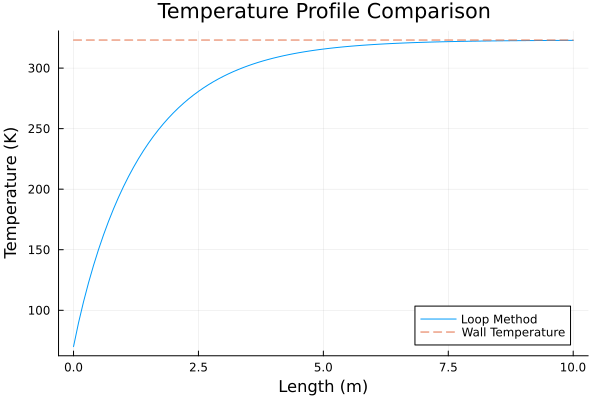

In [32]:
# Create comparison plot
p = plot(
    L_loop, T_loop,
    xlabel="Length (m)",
    ylabel="Temperature (K)",
    title="Temperature Profile Comparison",
    label="Loop Method"
)

plot!(
    L_loop, fill(T_Al, length(L_loop)),
    label="Wall Temperature",
    linestyle=:dash
)

display(p)

In [33]:
# Benchmark both methods
println("Benchmarking loop method:")
loop_bench = @btime heat_exchanger_loop($L, $dL, $h_in, $p_in, $ṁ, $fluid_model, $T_Al, $UA_over_dL);

Benchmarking loop method:
  126.600 μs (206 allocations: 4.97 KiB)
